### 1. Import Dependecies

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Loading the data

In [281]:
X_train = np.load('../artifacts/X_train.npz')['arr_0']
Y_train = np.load('../artifacts/Y_train.npz')['arr_0']
X_test = np.load('../artifacts/X_test.npz')['arr_0']
Y_test = np.load('../artifacts/Y_test.npz')['arr_0']

### 3. Model Training

#### 3.1 L1 Regularised Logistic Regression

In [282]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [283]:
def l1_log_regression(
                        X, Y, 
                        lr = 0.01, 
                        lambda_reg = 0.01,
                        iterations = 1000
                        ):
    n, m = X.shape 
    w = np.random.randn(m)
    b0 = 0

    loss_arr = []

    ''' 
    w = betas means weights
    '''

    for epoch in range(iterations):
        # Forward pass
        z = b0 + np.dot(X, w)
        Yhat = sigmoid(z)
        resid = Y - Yhat # residual means error terms
        
        # Compute gradients with L1 regularization
        s = np.where(w>=0, 1, -1)
        grad_w = -np.dot(X.T, resid) / n + lambda_reg * s # dw = grad_w
        grad_b = -np.mean(resid) # db = grad_b
        
        # Standard gradient descent update
        w = w - lr * grad_w
        b0 = b0 - lr * grad_b
        
        # Compute total loss (BCE + L1 penalty)

        # cost (binary cross entropy)
        pos_component = np.sum(Y * np.log(Yhat))
        neg_component = np.sum((1 - Y) * np.log(1 - Yhat))
        bce_loss = (-1/n) * (pos_component + neg_component)

        l1_panelty = lambda_reg * np.sum(np.abs(w))
        loss = bce_loss + l1_panelty
        loss_arr.append(loss)

    return w, b0, loss_arr

In [284]:
w, b0, loss_arr = l1_log_regression(X_train, Y_train)

print(f"best w : {w}")
print(f"best b0 : {b0}")

best w : [-4.66896196e-01 -3.97743470e-02 -2.51318909e-01 -5.32240617e-03
  2.15910384e-01  2.43243846e+00 -2.03338783e-06 -3.49651040e-02
 -4.07655301e-01  1.32805417e-01]
best b0 : -0.47845104933099364


In [285]:
def predict_proba(X, b0 ,w):
    z = b0 + np.dot(X, w)
    Y_proba = sigmoid(z)
    return Y_proba

In [286]:
def predict(X, w, b0, threshold=0.5):
    Y_proba = predict_proba(X, b0, w)
    return (Y_proba >= threshold).astype(int)

#### Evaluation Matrics

##### Confusion metrics

In [287]:
def compute_confusion_matrix(Y,Y_hat):
    TP = np.sum((Y == 1) & (Y_hat == 1))
    FP = np.sum((Y == 0) & (Y_hat == 1))
    TN = np.sum((Y == 0) & (Y_hat == 0))
    FN = np.sum((Y == 1) & (Y_hat == 0))
    return np.array([
                [TN,FP]
                ,[FN,TP]
                ],
                dtype=int
                )

In [288]:
Y_hat = predict(X_test, w, b0)
Y_proba = predict_proba(X_test, b0 ,w)

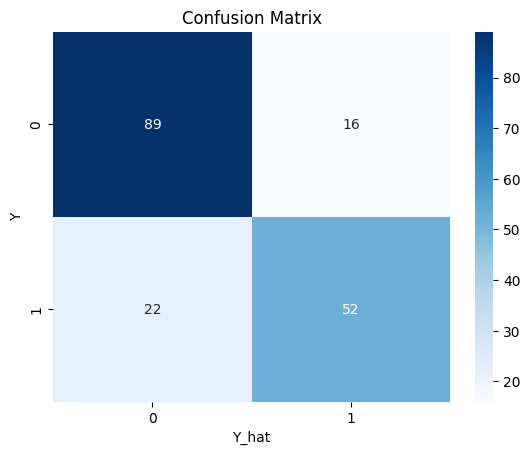

In [289]:
cm = compute_confusion_matrix(Y_test,Y_hat)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Y_hat')
plt.ylabel('Y')
plt.title('Confusion Matrix')
plt.show()

#### Precision, Recall, f1score, accuracy

In [290]:
def precision_score(cm):
    TP = cm[1,1]
    FP = cm[0,1]
    return TP/(TP+FP)

def recall_score(cm):
    TP = cm[1,1]
    FN = cm[1,0]
    return TP / (TP +FN)

def f1_score(cm):
    p = precision_score(cm)
    r = recall_score(cm)
    return 2 * p * r / (p + r)

def accuracy(cm):
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    TN = cm[0,0]
    return (TP + TN) / (TP + TN + FP + FN)

In [291]:
cm = compute_confusion_matrix(Y_test, Y_hat) 
p = precision_score(cm)
r = recall_score(cm) 
f1 = f1_score(cm)
acc = accuracy(cm)

print(f"Precision : {p}")
print(f"Recall : {r}")
print(f"F1 Score : {f1}")
print(f"Accuracy : {acc}")

Precision : 0.7647058823529411
Recall : 0.7027027027027027
F1 Score : 0.7323943661971832
Accuracy : 0.7877094972067039


##### ROC curve

In [292]:
# initializing empty arrays for store each precision and recall values for precision recall curve
Precision= []
Recall = []

In [293]:
def roc_curve(Y,Y_proba):
    thresholds = np.linspace(1,0,200)

    tpr_list = []
    fpr_list = []

    for t in thresholds:
        y_hat = (Y_proba >= t).astype(int)
        
        TP = np.sum((Y == 1) & (y_hat == 1))
        FP = np.sum((Y == 0) & (y_hat == 1))
        TN = np.sum((Y == 0) & (y_hat == 0))
        FN = np.sum((Y == 1) & (y_hat == 0))

        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)

        if (TP + FP) == 0:
            precision = 0 
        else:
            precision = TP / (TP + FP)

        recall = TP / (TP +FN)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        Precision.append(precision)
        Recall.append(recall)

    return np.array(tpr_list), np.array(fpr_list), np.array(thresholds)

In [294]:
tpr, fpr, _ = roc_curve(Y_test,Y_proba)

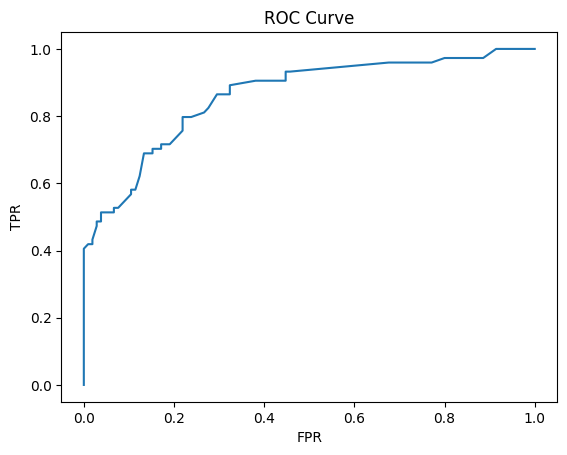

In [295]:
plt.plot(fpr, tpr, label='LogReg')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [296]:
auc = np.trapezoid(tpr, fpr)
print(f"AUC: {auc}")

AUC: 0.8617117117117118
